---
🌟 **Welcome to the AI Stylist Notebook!** 🌟

In this exciting journey, we're harnessing the power of the Gemini Pro-vision model to bring you an AI-based stylist. This isn't just any stylist - it's an **Explainable AI Stylist** that not only evaluates your fashion combinations but also suggests complementary products, complete with detailed explanations. 🤖👗

![AI_stylist](https://www.admind.ai/wp-content/uploads/2023/04/fashion-blog.png)


**Our Workflow:**
1. **Image Resizing:** To ensure we don’t exceed the model's rate limits, we start by resizing the images in our dataset. This makes our process more efficient and model-friendly. 🖼️↔️📏
2. **Evaluation by AI:** Based on your input, our AI stylist jumps into action, evaluating your fashion combinations with an expert eye. 🧐👚👖
3. **Complementary Recommendations:** What's more? Our AI goes a step further to recommend complementary products that perfectly match your chosen ensemble. It's like having a personal stylist in your pocket! 👜👠🕶️

🔥 But wait, there's more! If you're fascinated by AI and its wonders, check out my other notebook on **Transformers**. It's a deep dive into one of the most revolutionary architectures in AI today. [Check it out here](https://www.kaggle.com/code/memocan/sentiment-unveiled-bert-elmo-explored).

👍 If you find this notebook helpful, please consider giving it an upvote. And let's connect! Follow me for more AI adventures and insights. Let's learn and grow together in this amazing Kaggle community! 🚀🌐

---


---

**Gemini Pro Vision** is an advanced large language vision model from Gemini, designed to interpret and respond to both text and visual data (images and videos) along with textual information. This makes it a versatile foundation model for a multitude of multimodal tasks.

![gemini](https://eu-images.contentstack.com/v3/assets/blt6b0f74e5591baa03/blt8c91cc7ace2a21dd/657a136ef8bf3d040a7952f5/News_Image_-_2023-12-13T142522.594.png?width=850&auto=webp&quality=95&format=jpg&disable=upscale)

**Key Capabilities of Gemini Pro Vision:**
- **Multimodal Understanding**: Excelling in tasks that involve visual understanding, categorization, summarization, and content creation from images and videos.
- **Visual & Textual Input Processing**: Skillfully handles various types of visual and text inputs, including photos, documents, infographics, and screenshots.

**Potential Applications:**
- **Visual Information Retrieval**: Combines external knowledge with data extracted from images or videos to respond to queries.
- **Object Recognition**: Capable of detailed identification and answering questions related to objects within images and videos.
- **Digital Content Analysis**: Proficient in extracting information and answering queries based on visual content like infographics, charts, diagrams, tables, and web content.
- **Structured Response Generation**: Creates structured responses from multimodal inputs, utilizing formats such as HTML and JSON.
- **Image and Video Description**: Generates varying levels of detailed descriptions for both images and videos.
- **Reasoning Abilities**: Performs compositional inference to derive new information, going beyond mere memorization or retrieval.

---



# Table of Contents

1. [Preprocessing](#Preprocessing)
2. [Helper Functions](#Helper-Functions)
3. [First Combination (Men)](#First-Combination-(Men))
4. [Second Combination (Women)](#Second-Combination-(Women))


<a id='Preprocessing'></a>
## Preprocessing

In [1]:
from kaggle_secrets import UserSecretsClient
from IPython.display import display
from IPython.display import Markdown
import numpy as np # Importing numpy for linear algebra operations
import pandas as pd # Importing pandas for data processing, CSV file I/O
import matplotlib.pyplot as plt
import json
import pathlib
import textwrap
import pandas as pd
from PIL import Image
import os

# Initializing UserSecretsClient to access Kaggle secrets
user_secrets = UserSecretsClient()
apiKey = user_secrets.get_secret("GApiKey") # Retrieving API key stored in Kaggle secrets

import google.generativeai as genai
genai.configure(api_key = apiKey) # Configuring the generative AI module with the API key

model = genai.GenerativeModel('gemini-pro-vision') # Initializing the generative AI model

In [2]:
# Reading the images data from a CSV file
images_df = pd.read_csv("../input/fashion-product-images-dataset/fashion-dataset/images.csv")

# Reading the styles data from another CSV file, skipping bad lines if encountered
styles_df = pd.read_csv("../input/fashion-product-images-dataset/fashion-dataset/styles.csv", on_bad_lines='skip')

# Extracting the ID from the filename and converting it to an integer
images_df['id'] = images_df['filename'].apply(lambda x: x.replace(".jpg", "")).astype(int)

# Merging the images and styles dataframes on the 'id' column
# 'left' join ensures all entries in styles_df are included even if there's no matching image
data = styles_df.merge(images_df, on='id', how='left').reset_index(drop=True)

# Updating the 'filename' column to include the full path to the images
data['filename'] = data['filename'].apply(lambda x: os.path.join("../input/fashion-product-images-dataset/fashion-dataset/images/", x))

# Limiting the data to the first 6000 entries for simplicity
new_data = data[0:6000]


<a id='Helper-Functions'></a>
## Helper Functions

In [3]:
def load_image_from_dataset(product_id, dataframe):
    # Function to load an image from the dataset based on product ID
    file_path = dataframe[dataframe['id'] == product_id]['filename'].iloc[0]
    try:
        return Image.open(file_path)
    except IOError:
        print(f"Cannot load image for product ID {product_id}")
        return None

In [4]:
def get_combination_feedback(user_selected_product_ids, data, model):
    # Load images for the selected product IDs
    selected_images = [load_image_from_dataset(pid, data) for pid in user_selected_product_ids]

    # Start constructing the contents list
    contents = ["Here are images of the selected products:"]
    
    # Add each product and its image to the contents list
    for i, img in enumerate(selected_images):
        product_entry = f"Product {i+1}:"
        image_entry = img
        contents.extend([product_entry, image_entry])

    # Add the question to the contents list
    question =  "Based on their style, color, material, and overall appearance, can these products be combined and look great? Return in JSON with decision and reason:"
    contents.append(question)

    # Call to the generative AI model
    responses = model.generate_content(contents, stream=True)
    all_responses = [response.text for response in responses]
    decision, reason = parse_response(all_responses)
    return decision, reason

In [5]:
def parse_response(response_parts):
    try:
        # Concatenate the response parts into a single string
        concatenated_response = ''.join(response_parts)

        # Remove markdown formatting for JSON
        cleaned_response = concatenated_response.replace('```json', '').replace('```', '').strip()

        # Parse the cleaned response as JSON
        response_json = json.loads(cleaned_response)

        # Extract decision and reason
        decision = response_json.get("decision", "Unknown")
        reason = response_json.get("reason", "No reason provided")
        return decision, reason
    except json.JSONDecodeError:
        return "Unknown", "Response parsing error"


In [6]:
def recommend_complementary_products(user_selected_product_ids, decision, data, model):
    # Check if the decision is 'yes' and proceed
    if decision == 'yes':
        # Load images for the selected product IDs
        selected_images = [load_image_from_dataset(pid, data) for pid in user_selected_product_ids]

        # Construct the prompt for the generative AI model
        contents_complementary = ["Based on the following combined products:"]
        
        # Add the combined product images to the contents
        for i, img in enumerate(selected_images):
            contents_complementary.extend([f"Combined Product {i+1}:", img])

        # Add the request for a complementary product
        contents_complementary.append(
            "Recommend complementary products that would enhance this combination. Please ensure the recommendation is specifically tailored to these combined products.Please return in JSON with the product category, color, intended usage (such as formal, casual, etc.),and reason for your recommendation:"
        )

        # Call to the generative AI model
        responses_complementary = model.generate_content(contents_complementary, stream=True)
        
        responses_complementary = parse_and_format_recommendations(responses_complementary)

        # Return the responses
        return responses_complementary
    else:
        return ["The decision was 'no', so no complementary product is recommended."]

In [7]:
def parse_and_format_recommendations(responses):
    # Concatenate the response parts into a single string
    concatenated_response = ''.join([response.text for response in responses])

    # Remove any potential markdown formatting
    cleaned_response = concatenated_response.replace('```json', '').replace('```', '').strip()

    try:
        # Parse the cleaned response as JSON
        response_json = json.loads(cleaned_response)

        # Extract and format the recommended products
        recommended_products = response_json.get("products", [])
        formatted_recommendations = {}

        for i, product in enumerate(recommended_products, 1):
            formatted_recommendations[f"Recommended Product {i}"] = {
                "category": product.get("category", "Unknown"),
                "color": product.get("color", "Unknown"),
                "usage": product.get("usage", "Unknown"),
                "reason": product.get("reason", "No reason provided")
            }

        return formatted_recommendations
    except json.JSONDecodeError:
        return "Error parsing response as JSON"


In [8]:
def process_images(dataframe, resize_dimensions, quality, processed_image_dir):
    # Ensure the processed image directory exists
    os.makedirs(processed_image_dir, exist_ok=True)

    # Create a copy of the DataFrame to avoid modifying the original
    processed_data = dataframe.copy()

    total_images = len(processed_data)
    print(f"Starting image processing for {total_images} images.")

    # Process each image
    for index, row in processed_data.iterrows():
        original_path = row['filename']
        try:
            # Load image
            img = Image.open(original_path)
            # Resize or compress the image
            img_resized = img.resize(resize_dimensions)
            new_path = os.path.join(processed_image_dir, os.path.basename(original_path))
            img_resized.save(new_path, 'JPEG', quality=quality)

            # Update the DataFrame with the new file path
            processed_data.at[index, 'filename'] = new_path

            # Print progress
            if (index + 1) % 100 == 0 or (index + 1) == total_images:
                print(f"Processed {index + 1}/{total_images} images.")

        except IOError as e:
            print(f"Error processing image {original_path}: {e}")

    print("Image processing completed.")
    return processed_data


In [9]:
def display_combination_feedback(user_selected_product_ids, dataframe, model):
    # Call the function to get combination feedback
    decision, reason = get_combination_feedback(user_selected_product_ids, dataframe, model)

    # Load and display images
    fig, axes = plt.subplots(1, len(user_selected_product_ids), figsize=(15, 5))
    for i, pid in enumerate(user_selected_product_ids):
        path = dataframe[dataframe['id'] == pid]['filename'].iloc[0]
        img = Image.open(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Product {pid}")

    plt.show()

    # Display decision and reason
    print(f"AI Stylist's Decision: {decision}")
    print("Reason:", reason)

<a id='First-Combination-(Men)'></a>
## First Combination (Men)

In [10]:
new_data = process_images(new_data, (700, 700), 85, 'processed_images')

Starting image processing for 6000 images.
Processed 100/6000 images.
Processed 200/6000 images.
Processed 300/6000 images.
Processed 400/6000 images.
Processed 500/6000 images.
Processed 600/6000 images.
Processed 700/6000 images.
Processed 800/6000 images.
Processed 900/6000 images.
Processed 1000/6000 images.
Processed 1100/6000 images.
Processed 1200/6000 images.
Processed 1300/6000 images.
Processed 1400/6000 images.
Processed 1500/6000 images.
Processed 1600/6000 images.
Processed 1700/6000 images.
Processed 1800/6000 images.
Processed 1900/6000 images.
Processed 2000/6000 images.
Processed 2100/6000 images.
Processed 2200/6000 images.
Processed 2300/6000 images.
Processed 2400/6000 images.
Processed 2500/6000 images.
Processed 2600/6000 images.
Processed 2700/6000 images.
Processed 2800/6000 images.
Processed 2900/6000 images.
Processed 3000/6000 images.
Processed 3100/6000 images.
Processed 3200/6000 images.
Processed 3300/6000 images.
Processed 3400/6000 images.
Processed 3500

In [19]:
user_selected_product_ids = [15970, 39386, 29114]  # User input

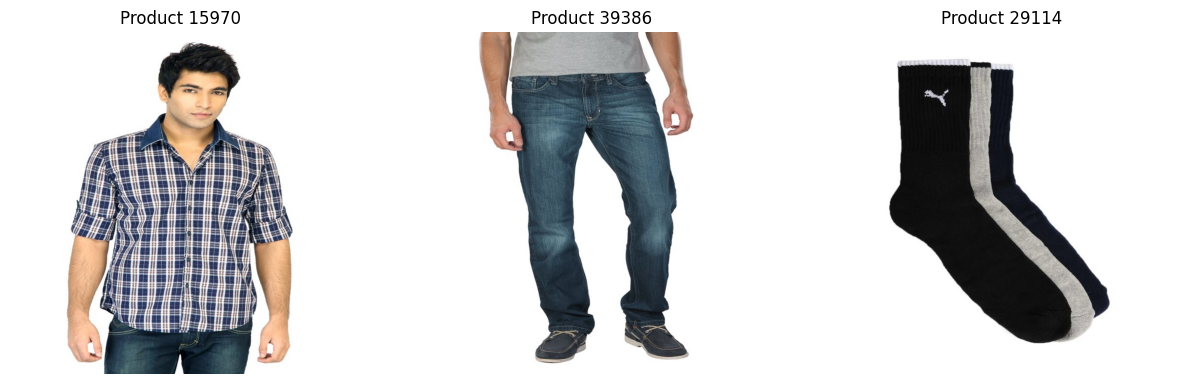

AI Stylist's Decision: yes
Reason: The products are all in the same color scheme and have a casual style. The shirt is a good match for the jeans, and the socks are a good match for both the shirt and the jeans.


In [21]:
decision,reason = get_combination_feedback(user_selected_product_ids, new_data, model)
display_combination_feedback(user_selected_product_ids, new_data, model)

In [23]:
responses_complementary = recommend_complementary_products(user_selected_product_ids, decision, new_data, model)
responses_complementary

{'Recommended Product 1': {'category': 'Shoes',
  'color': 'Brown',
  'usage': 'Casual',
  'reason': 'Brown shoes would complement the blue jeans and white shirt, creating a casual look.'},
 'Recommended Product 2': {'category': 'Belt',
  'color': 'Black',
  'usage': 'Formal',
  'reason': 'A black belt would add a touch of formality to the outfit, making it suitable for a more formal occasion.'},
 'Recommended Product 3': {'category': 'Watch',
  'color': 'Silver',
  'usage': 'Formal',
  'reason': 'A silver watch would add a touch of class to the outfit, making it suitable for a formal occasion.'}}

<a id='Second-Combination-(Women)'></a>
## Second Combination (Women)


In [36]:
user_selected_product_ids = [26960,7193]  # User input
decision,reason = get_combination_feedback(user_selected_product_ids, new_data, model)

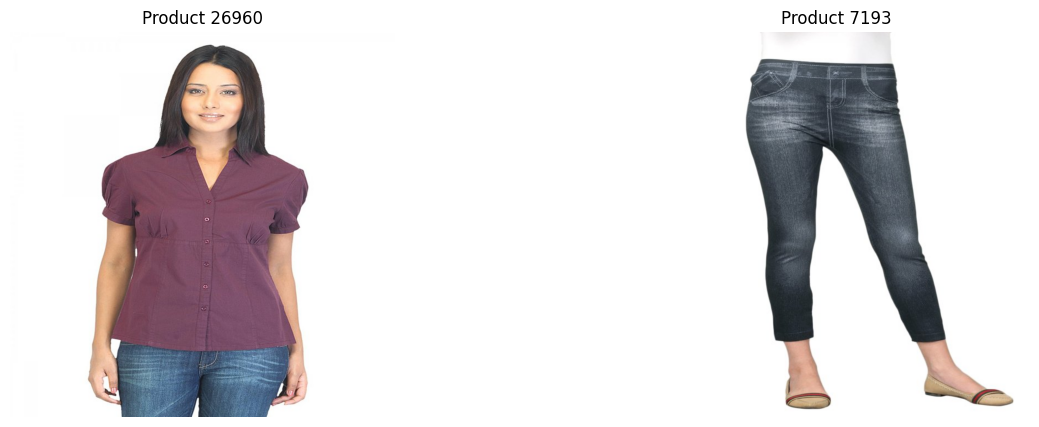

AI Stylist's Decision: yes
Reason: The shirt is a dark purple color, which will go well with the dark blue color of the jeans. Both items are made of cotton, so they will have a similar texture. The shirt is also a good length to wear with the jeans.


In [37]:
display_combination_feedback(user_selected_product_ids, new_data, model)

In [39]:
responses_complementary = recommend_complementary_products(user_selected_product_ids, decision, new_data, model)
responses_complementary

{'Recommended Product 1': {'category': 'footwear',
  'color': 'black',
  'usage': 'casual',
  'reason': 'A pair of black flats would complement the purple blouse and dark jeans, creating a casual and polished look.'},
 'Recommended Product 2': {'category': 'accessories',
  'color': 'black',
  'usage': 'formal',
  'reason': 'A black handbag would add a touch of sophistication to the outfit, making it suitable for a formal occasion.'},
 'Recommended Product 3': {'category': 'jewelry',
  'color': 'silver',
  'usage': 'casual',
  'reason': 'A silver necklace or earrings would add a touch of glamour to the outfit, making it perfect for a night out.'}}